In [39]:
import os
import PyPDF2
import pandas as pd

In [40]:
PDFS_DIR = "./pdfs/"

pdfs_processed = []
for root, dirs, files in os.walk(PDFS_DIR, topdown=False):
    for name in files:
        pdfs_processed.append({'path':os.path.join(root, name), 'name':name.split(".")[0].split("_")[0], 'id':name.split(".")[0].split("_")[1]})

In [41]:
texts = []
names = []
ids   = []

data = []

for pdf in pdfs_processed:

    with open(pdf['path'],'rb') as pdf_file:
 
        pdfreader = PyPDF2.PdfReader(pdf_file)

        x = len(pdfreader.pages)

        pageobj=pdfreader.pages[0] # -> x + 1 because python start in 0, so 0 + 1 => page 1 (start)

        point = [pdf['id'], pdf['name'], pageobj.extract_text().replace("[", "(").replace("]", ")")]
        
        data.append(point)
        
    pdf_file.close()



In [42]:
pdf_df = pd.DataFrame(data, columns=['text_id', 'title', 'text'])

In [43]:
pdf_df

,text_id,title,text
0,1706,attention,"Provided proper attribution is provided, Googl..."
1,2103,crispr-cas9,arXiv:2103.10667v2 (q-bio.SC) 4 Oct 2021Sear...
2,2401,mamba,MambaByte: Token-free Selective State Space Mo...
3,1404,pca,A Tutorial on Principal Component Analysis\nJo...
4,2304,rnn,To appear as a part of an upcoming textbook on...
5,attention,self,STORY DIFFUSION : C ONSISTENT SELF-ATTENTION\n...
6,1812,xnet,XNet: A convolutional neural network (CNN)\nim...


In [44]:
from sentence_transformers import SentenceTransformer

def embed_text(text): 
    
    model = SentenceTransformer('all-mpnet-base-v2')
#     model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

    response = model.encode(text, convert_to_tensor=True)

    response = response.cpu().detach().numpy()

    return response

In [45]:
pdf_df['text_vector'] = pdf_df['text'].apply(embed_text)

C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [46]:
import seaborn as sns
from sklearn.decomposition import PCA

In [47]:
# retrieve the embedding vectors from the search results
vectors = pdf_df.loc[:, "text_vector"].to_list()

# apply PCA to reduce the dimensionality of the vectors to 3 dimensions
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# create a dataframe with the reduced vectors
new_pca_df = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2'])

new_pca_df['text_lenght'] = pdf_df['text'].apply(len)
new_pca_df['title'] = pdf_df['title']

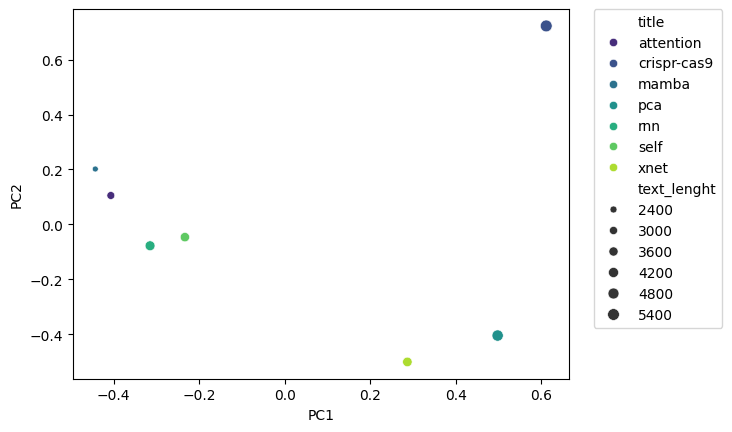

In [48]:
# for creating a responsive plot
import ipympl
%matplotlib widget
%matplotlib inline

import matplotlib.pyplot as plt

# use seaborn's scatterplot function to visualize the clusters
sns.scatterplot(data=new_pca_df, x='PC1', y='PC2', hue='title', size='text_lenght', palette='viridis')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

In [49]:

# retrieve the embedding vectors from the search results
vectors = pdf_df.loc[:, "text_vector"].to_list()

# apply PCA to reduce the dimensionality of the vectors to 3 dimensions
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(vectors)

# create a dataframe with the reduced vectors
new_pca_df = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2', 'PC3'])

new_pca_df['text_lenght'] = pdf_df['text'].apply(len)
new_pca_df['title'] = pdf_df['title']


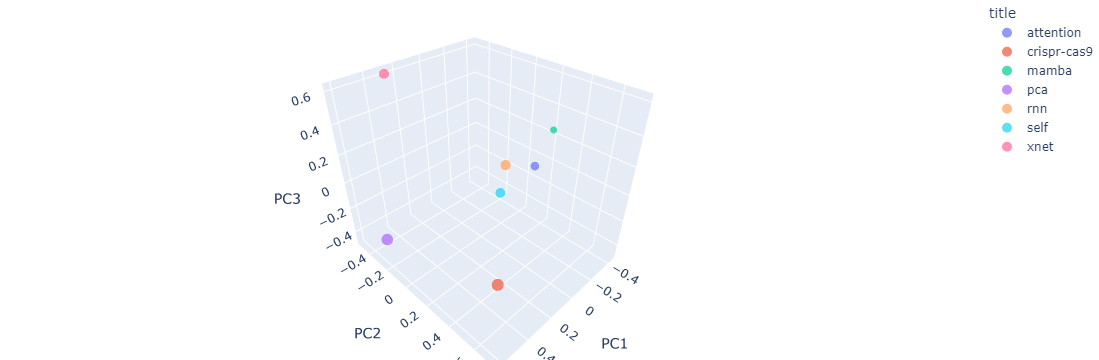

In [50]:
import plotly.express as px

%matplotlib widget
%matplotlib inline

# Configure the trace.
fig = px.scatter_3d(new_pca_df,
    x='PC1',  # <-- Put your data instead
    y='PC2',  # <-- Put your data instead
    z='PC3',  # <-- Put your data instead
    size='text_lenght',
    color='title'
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [51]:
import numpy as np

In [52]:
# -> Semantic Search

search_string = "Deep Reinforcement learning"

paraphrase_vector = embed_text(search_string)

C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [53]:
import pandas as pd
import numpy as np

# Assuming pdf_df is your original DataFrame and it's already loaded
pdf_df_copy = pdf_df.copy()

# Create a new row with appropriate data types
new_row = pd.DataFrame({
    'text_id': [0],
    'title': ['Our Search'],
    'text': [search_string],
    'text_vector': [np.array(paraphrase_vector)]  # Ensure this is a NumPy array
})

# Append the new row using concat
pdf_df_copy = pd.concat([pdf_df_copy, new_row], ignore_index=True)

# Calculate distances
def calculate_distance(x, base_vector):
    # Ensure x is a NumPy array
    if isinstance(x, list):
        x = np.array(x)
    elif isinstance(x, str):
        x = np.array(eval(x))  # Use eval if stored as string representation of list/array
    return np.linalg.norm(x - base_vector)

# Apply function to calculate distances
base_vector = np.array(paraphrase_vector)  # Ensure this is a NumPy array
pdf_df_copy['distance'] = pdf_df_copy['text_vector'].apply(lambda x: calculate_distance(x, base_vector))

# Sort DataFrame by 'distance'
pdf_df_copy = pdf_df_copy.sort_values(by='distance')


In [54]:
pdf_df_copy.head()

,text_id,title,text,text_vector,distance
7,0,Our Search,Deep Reinforcement learning,"[-0.026842538, 0.03865101, -0.018913055, 0.025...",0.000000
4,2304,rnn,To appear as a part of an upcoming textbook on...,"[-0.0037181564, 0.016733125, -0.020747423, 0.0...",1.070841
0,1706,attention,"Provided proper attribution is provided, Googl...","[0.0054992014, 0.037146155, 0.0010611548, 0.02...",1.141667
2,2401,mamba,MambaByte: Token-free Selective State Space Mo...,"[0.05232658, 0.051375307, -0.0006775561, 0.002...",1.179760
5,attention,self,STORY DIFFUSION : C ONSISTENT SELF-ATTENTION\n...,"[0.011601232, 0.020899585, 0.01922862, 0.02535...",1.205334


In [55]:
pdf_df_copy = pdf_df_copy.reset_index(drop=True)

In [56]:
pdf_df_copy

,text_id,title,text,text_vector,distance
0,0,Our Search,Deep Reinforcement learning,"[-0.026842538, 0.03865101, -0.018913055, 0.025...",0.000000
1,2304,rnn,To appear as a part of an upcoming textbook on...,"[-0.0037181564, 0.016733125, -0.020747423, 0.0...",1.070841
2,1706,attention,"Provided proper attribution is provided, Googl...","[0.0054992014, 0.037146155, 0.0010611548, 0.02...",1.141667
3,2401,mamba,MambaByte: Token-free Selective State Space Mo...,"[0.05232658, 0.051375307, -0.0006775561, 0.002...",1.179760
4,attention,self,STORY DIFFUSION : C ONSISTENT SELF-ATTENTION\n...,"[0.011601232, 0.020899585, 0.01922862, 0.02535...",1.205334
5,1812,xnet,XNet: A convolutional neural network (CNN)\nim...,"[0.016950995, 0.025170336, -0.017331049, 0.016...",1.250568
6,1404,pca,A Tutorial on Principal Component Analysis\nJo...,"[-0.043667298, 0.027209371, -0.049346946, 0.02...",1.268179
7,2103,crispr-cas9,arXiv:2103.10667v2 (q-bio.SC) 4 Oct 2021Sear...,"[-0.008727858, -0.10015887, -0.0042581153, 0.0...",1.314120


In [57]:
# retrieve the embedding vectors from the search results
vectors = pdf_df_copy.loc[:, "text_vector"].to_list()

# apply PCA to reduce the dimensionality of the vectors to 3 dimensions
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(vectors)

# create a dataframe with the reduced vectors
new_pca_df = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2', 'PC3'])

new_pca_df['text_lenght'] = pdf_df_copy['text'].apply(len)
new_pca_df['distance'] = pdf_df_copy['distance']
new_pca_df['title'] = pdf_df_copy['title']

In [58]:
new_pca_df['distance_group'] = pd.cut(new_pca_df['distance'], bins=5, labels=False)

In [59]:
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
new_pca_df['marker'] = new_pca_df['distance_group'].apply(lambda x: markers[x])

In [60]:
new_pca_df

,PC1,PC2,PC3,text_lenght,distance,title,distance_group,marker
0,-0.015672,0.021249,0.473040,27,0.000000,Our Search,0,.
1,-0.313762,-0.078498,-0.030232,4022,1.070841,rnn,4,^
2,-0.403850,0.101101,-0.149495,2853,1.141667,attention,4,^
3,-0.440594,0.198536,0.130286,1944,1.179760,mamba,4,^
4,-0.230071,-0.051622,-0.402651,3695,1.205334,self,4,^
5,0.289391,-0.503179,0.405725,3811,1.250568,xnet,4,^
6,0.500871,-0.407939,-0.414382,5020,1.268179,pca,4,^
7,0.613686,0.720352,-0.012290,5463,1.314120,crispr-cas9,4,^


In [61]:
from sklearn.cluster import KMeans

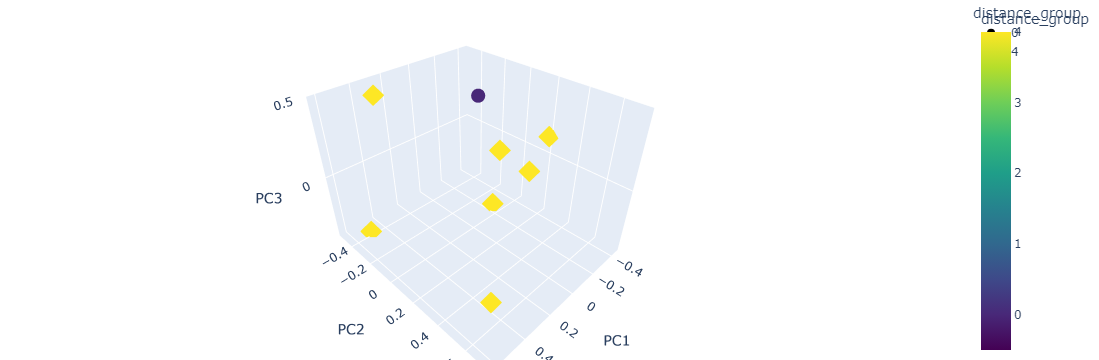

In [62]:
# Configure the trace.

fig = px.scatter_3d(new_pca_df,
    x='PC1',  # <-- Put your data instead
    y='PC2',  # <-- Put your data instead
    z='PC3',  # <-- Put your data instead
#   size='text_lenght',
    color='distance_group',
    symbol='distance_group',
    hover_name='title',
    color_continuous_scale=px.colors.sequential.Viridis
)

# av colors:
# colors:
# ['Alphabet',
#  'Antique',
#  'Bold',
#  'D3',
#  'Dark2',
#  'Dark24',
#  'G10',......]

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [63]:
pdf_df_copy

,text_id,title,text,text_vector,distance
0,0,Our Search,Deep Reinforcement learning,"[-0.026842538, 0.03865101, -0.018913055, 0.025...",0.000000
1,2304,rnn,To appear as a part of an upcoming textbook on...,"[-0.0037181564, 0.016733125, -0.020747423, 0.0...",1.070841
2,1706,attention,"Provided proper attribution is provided, Googl...","[0.0054992014, 0.037146155, 0.0010611548, 0.02...",1.141667
3,2401,mamba,MambaByte: Token-free Selective State Space Mo...,"[0.05232658, 0.051375307, -0.0006775561, 0.002...",1.179760
4,attention,self,STORY DIFFUSION : C ONSISTENT SELF-ATTENTION\n...,"[0.011601232, 0.020899585, 0.01922862, 0.02535...",1.205334
5,1812,xnet,XNet: A convolutional neural network (CNN)\nim...,"[0.016950995, 0.025170336, -0.017331049, 0.016...",1.250568
6,1404,pca,A Tutorial on Principal Component Analysis\nJo...,"[-0.043667298, 0.027209371, -0.049346946, 0.02...",1.268179
7,2103,crispr-cas9,arXiv:2103.10667v2 (q-bio.SC) 4 Oct 2021Sear...,"[-0.008727858, -0.10015887, -0.0042581153, 0.0...",1.314120


In [64]:

# Fit the K-means clustering algorithm to the reduced vectors
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(new_pca_df[['PC1', 'PC2', 'PC3']])

# Obtain the cluster labels
labels = kmeans.labels_

# Assign the cluster labels to the DataFrame
new_pca_df['Cluster'] = labels

In [65]:
# Group the embeddings by cluster
clusters = {}
for i, embedding in enumerate(vectors):
    cluster_label = labels[i]
    if cluster_label not in clusters:
        clusters[cluster_label] = []
    clusters[cluster_label].append(vectors)

In [66]:
# Add pdfs names to the clusters
pdfs_names = pdf_df_copy['title'].to_list()

data = []

for label, embeddings in clusters.items():
    
#     print (label)
    
    for i, _ in enumerate(embeddings):
        
        key =label
        title = pdfs_names[i]                               
                                                
        data.append((key, i, title))   

In [67]:
data

[(0, 0, 'Our Search'),
 (0, 1, 'rnn'),
 (0, 2, 'attention'),
 (0, 3, 'mamba'),
 (0, 4, 'self'),
 (1, 0, 'Our Search'),
 (1, 1, 'rnn'),
 (2, 0, 'Our Search')]

In [68]:
# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['Key', 'Index', 'Value'])

# Set 'Key' and 'Index' as a multi-index
df = df.set_index(['Key', 'Index'])

In [69]:
df

Value
Key Index            
0   0      Our Search
    1             rnn
    2       attention
    3           mamba
    4            self
1   0      Our Search
    1             rnn
2   0      Our Search

In [70]:
group = df.loc[1] # Select a group by key

In [71]:
group

,Value
Index,
0,Our Search
1,rnn


In [72]:
row = group.loc[0, 'Value'] # Select an index inside the group

In [73]:
row

'Our Search'